# Train script for Advanced RNN VAE model

### imports

In [1]:
%matplotlib inline

from torch.autograd import Variable
from torch import optim
from torch.utils.data import DataLoader
import torch

import sys
sys.path.append("../../Modules")
sys.path.append("../../Datasets")

# local imports
from train import train_twitter
from helpers import kl_loss,nll_loss,mse_loss,kl_loss_multi
from models import AdvancedRNNVAE
from babelDatasets.sentiment140 import Sentiment140
from babelDatasets.utils import padding_merge

## Define dataset loader

In [2]:
batch_size = 32

data_loader = DataLoader(Sentiment140(data_directory="../../Datasets/Data",train=True,max_sentence_size=32),batch_size=batch_size,shuffle=True,collate_fn=padding_merge)
valid_data_loader = DataLoader(Sentiment140(data_directory="../../Datasets/Data",train=False,max_sentence_size=32),batch_size=batch_size,shuffle=True,collate_fn=padding_merge)

num_classes = 82

batch_loader = iter(data_loader)
valid_batch_loader = iter(valid_data_loader)
# input has shape [batch_size,seq_len,1]

# N sents: 150000  train: True  sentences_path: ../../Datasets/Data/train_sentences.txt
# N sents: 52990  train: False  sentences_path: ../../Datasets/Data/test_sentences.txt


## Define model

In [3]:
model = AdvancedRNNVAE(input_size=1,rnn_size=256,latent_size=64,output_size=num_classes,use_softmax=True,bidirectional=True)
print("Number of trainable parameters {}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# test forward pass
try:
    initial_batch = batch_loader.next()[0]
    x = Variable(torch.FloatTensor(initial_batch)).transpose(1,0).unsqueeze(2)
    test,_ = model(x)
    assert (test.shape[0] == x.shape[0] and test.shape[1] == x.shape[1] and test.shape[2] == num_classes)
    print("Forward pass succesfull")
except:
    print("Error in forward pass. Output should have shape: {} but had {}".format(x.contiguous().view(-1).shape,test.view(-1).shape))

Number of trainable parameters 896722
Forward pass succesfull


## Define optimizer and loss

In [4]:
learning_rate = 1e-4
optimizer = optim.Adam(model.parameters(),lr=learning_rate,weight_decay=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,mode="min",factor=0.5,verbose=True,cooldown=2)

## Define trainer


Train (1 5%) elbo: -0.8648 r_loss: -0.8648 kl: 39635.9123 aux_loss: 0.0000 beta 0.00e+00
Valid (1 5%) elbo: -0.3456 r_loss: -0.3456 kl: 65916.9766 aux_loss: 0.0000 beta 0.00e+00

Train (2 10%) elbo: -1.0218 r_loss: -0.7000 kl: 611.4265 aux_loss: 0.0000 beta 5.26e-04
Valid (2 10%) elbo: -0.6868 r_loss: -0.5066 kl: 342.4443 aux_loss: 0.0000 beta 5.26e-04

Train (3 15%) elbo: -0.7980 r_loss: -0.5426 kl: 242.6562 aux_loss: 0.0000 beta 1.05e-03
Valid (3 15%) elbo: -0.6834 r_loss: -0.4362 kl: 234.8174 aux_loss: 0.0000 beta 1.05e-03

Train (4 20%) elbo: -0.8240 r_loss: -0.5388 kl: 180.6187 aux_loss: 0.0000 beta 1.58e-03
Valid (4 20%) elbo: -0.9526 r_loss: -0.6536 kl: 189.3621 aux_loss: 0.0000 beta 1.58e-03

Train (5 25%) elbo: -0.8609 r_loss: -0.5461 kl: 149.5225 aux_loss: 0.0000 beta 2.11e-03
Valid (5 25%) elbo: -0.8714 r_loss: -0.5478 kl: 153.7319 aux_loss: 0.0000 beta 2.11e-03

Train (6 30%) elbo: -0.9045 r_loss: -0.5569 kl: 132.1083 aux_loss: 0.0000 beta 2.63e-03
Valid (6 30%) elbo: -0.7

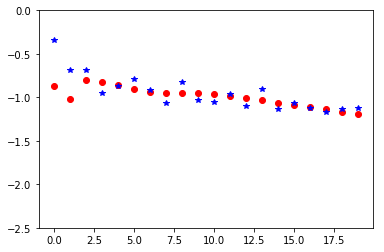

In [5]:
# use at least 50 iterations to get good results
train_twitter(data_loader,valid_data_loader,model,optimizer,scheduler,loss_fn=nll_loss,kl_loss_fn=kl_loss_multi,n_iters=20,use_softmax=True,max_beta=1e-2,print_every=1,plot_pred=False,max_batches=3000)

In [8]:
#torch.save(model.state_dict(),"../../Saved_models/Sentiment140/RNNVAE_nll_map.pt")

Train (20 100%) elbo: -1.1901 r_loss: -0.6144 kl: 57.5669 aux_loss: 0.0000 beta 1.00e-02

Valid (20 100%) elbo: -1.1232 r_loss: -0.5846 kl: 53.8622 aux_loss: 0.0000 beta 1.00e-02